# coding

In [41]:
import warnings

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (70000, 784)
y shape: (70000,)


In [19]:
def plot_img(image_data, shape):
    plt.imshow(image_data.reshape(shape), cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

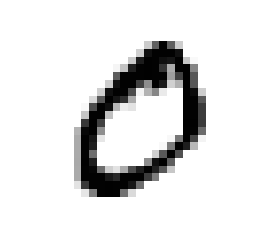

In [20]:
plot_img(X[0], shape=(28, 28))

In [21]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [23]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [24]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [25]:
from sklearn.linear_model import SGDClassifier

In [26]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [35]:
sgd_clf.predict([X[35000]])

array([ True])

使用交叉验证评估结果

In [46]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct * 1. / len(y_pred))

0.0965
0.09895
0.0995


In [45]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9597 , 0.9629 , 0.96945])

In [47]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53895,   684],
       [ 1475,  3946]])

In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("precision:", precision_score(y_train_5, y_train_pred))
print("recall:", recall_score(y_train_5, y_train_pred))
print("f1:", f1_score(y_train_5, y_train_pred))

precision: 0.8522678185745141
recall: 0.7279099797085409
f1: 0.7851955029350313


## 评估(准确率召回率阈值曲线)

In [57]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [58]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [66]:
def plot_precision_recall_vs_thresold(precisions, recalls, thresholds=None):
    if thresholds is not None:
        plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
        plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
        plt.xlabel("Threshold")
        plt.legend()
        plt.ylim([0, 1])
    else:
        plt.plot(recalls, precisions)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("precision vs recall")

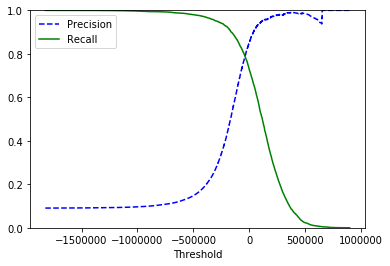

In [67]:
plot_precision_recall_vs_thresold(precisions, recalls, thresholds)

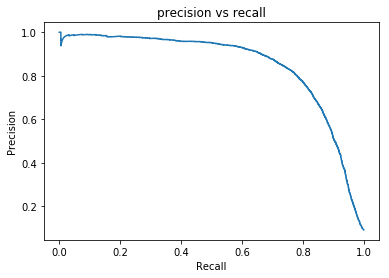

In [69]:
plot_precision_recall_vs_thresold(precisions, recalls)

In [70]:
y_train_pred_90 = (y_scores > 70000)
print("precision:", precision_score(y_train_5, y_train_pred_90))
print("recall:", recall_score(y_train_5, y_train_pred_90))
print("f1:", f1_score(y_train_5, y_train_pred_90))

precision: 0.9304997128087306
recall: 0.5976757055893747
f1: 0.7278445467819836


## ROC曲线

In [72]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [75]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

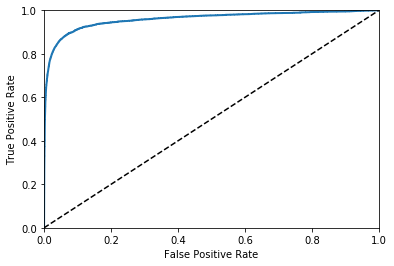

In [76]:
plot_roc_curve(fpr, tpr)

In [78]:
from sklearn.metrics import roc_auc_score

In [80]:
roc_auc_score(y_train_5, y_scores)

0.9593538991536561

### 与RandomForrest对比

In [82]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [83]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

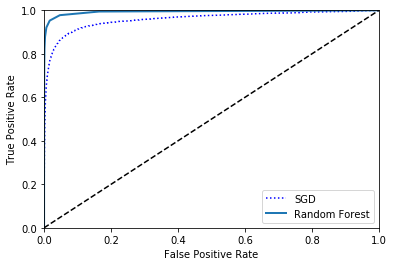

In [88]:
plt.plot(fpr, tpr, 'b:', label='SGD')
# plot_roc_curve(fpr, tpr, "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend()

In [90]:
roc_auc_score(y_train_5, y_scores_forest)

0.9934519639234511

## 多类别分类

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [92]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90806839, 0.90564528, 0.91368705])

### 分析误差

In [93]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    2,   25,   10,   10,   44,   44,    8,   39,    7],
       [   1, 6461,   43,   26,    7,   46,    7,   11,  126,   14],
       [  52,   33, 5349,  105,   85,   26,   89,   51,  154,   14],
       [  54,   40,  143, 5320,    2,  239,   39,   52,  136,  106],
       [  25,   26,   37,   10, 5372,    7,   51,   28,   86,  200],
       [  67,   37,   30,  181,   71, 4624,  112,   26,  173,  100],
       [  31,   20,   47,    1,   41,   99, 5623,    9,   47,    0],
       [  21,   18,   75,   30,   46,   12,    4, 5767,   16,  276],
       [  53,  150,   78,  162,   14,  163,   56,   24, 5012,  139],
       [  42,   30,   32,   84,  161,   34,    2,  201,   77, 5286]])

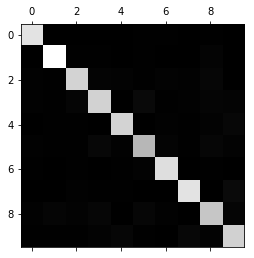

In [94]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

仅仅关注包含误差的数据

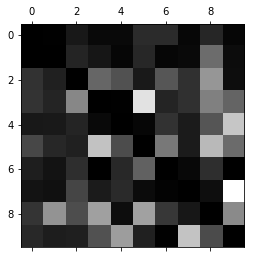

In [95]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

## 多标签分类

## 多输出分类

In [96]:
noise = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise_test
y_train_mod = X_train[:]
y_test_mod = X_test[:]

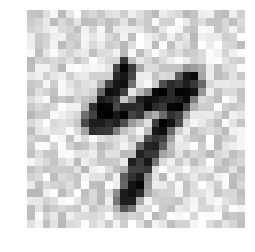

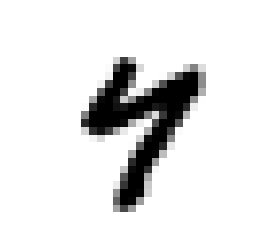

In [99]:
plot_img(X_train_mod[0], shape=(28, 28))
plot_img(y_train_mod[0], shape=(28, 28))

In [110]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
print("train finished.")
clean_digit = knn_clf.predict([X_test_mod[0]])

train finished.


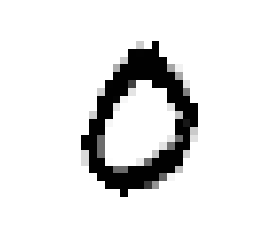

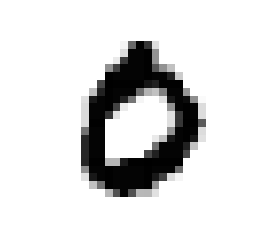

In [107]:
plot_img(clean_digit[0], shape=(28, 28))
plot_img(y_test_mod[0], shape=(28, 28))

# notes

## 分类器的评估

### 二分类

#### 混淆矩阵

用于判断$TP$、$FP$等数值

准确率：$precision = \cfrac{TP}{TP + FP}$

召回率：$recall = \cfrac{TP}{TP + FN}$

F1值：$F1 = \cfrac{2}{\cfrac{1}{precision} + \cfrac{1}{recall}} = 2 * \cfrac{precision * recall}{precision + recall} = \cfrac{TP}{TP + \cfrac{FN + FP}{2}}$

准确率和召回率之间需要权衡

#### 准确率和召回率的调整

`sklearn` 中分类器的 `decision_function` 方法，产生决策分数，从而通过控制阈值，达到不同的准确率和召回率

#### 如何判断使用哪个阈值

1. 在进行预测的时候，不输出类别，而是输出每个样本的决策分数
2. 使用 `precision_recall_curve` 找到准确率、召回率、阈值
3. 画出准确率、召回率和阈值的曲线，或，画出准确率召回率曲线

#### ROC曲线

- TPR: 也就是召回率
- FPR: 假正例率
- TNR: 特异性

ROC曲线就是画出召回率对(1-特异性)的曲线

#### AUC分数

即ROC曲线与坐标轴围城的面积。一个完全随机的分类器AUC分数为0.5。

**\*如何选择两者：**

优先使用PR曲线：正例很少、当你关注假正例多余假反例

ROC曲线：其他情况

### 多类别分类

#### 误差分析

1. 使用混淆矩阵

### 多标签分类

### 多输出分类

## 整体Pipeline

1. 如何选择好的量度标准
2. 挑选合适的准确率/召回率折衷方案
3. 比较分类器